In [ ]:
import zipfile
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image, ImageEnhance
import random
import shutil
import cv2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = "/content/drive/MyDrive/FODS PROJECT FOLDER/German Dataset.zip"
extract_path = "GTS"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files extracted to:", extract_path)

Files extracted to: GTS


In [ ]:
german_base = "GTS"

german_train_csv = os.path.join(german_base, "Train.csv")
german_train_img_base = os.path.join(german_base, "Train")

german_test_csv = os.path.join(german_base, "Test.csv")
german_test_img_base = os.path.join(german_base, "Test")



ge_train_df = pd.read_csv(german_train_csv)
ge_test_df = pd.read_csv(german_test_csv)


print("German Train CSV shape:", ge_train_df.shape)
print("German Test CSV shape:", ge_test_df.shape)



German Train CSV shape: (39209, 8)
German Test CSV shape: (12630, 8)


In [ ]:

# Remove unnecessary columns
ge_train_df = ge_train_df.drop(columns=['new_filename', 'image_path'], errors='ignore')
ge_test_df = ge_test_df.drop(columns=['image_path'], errors='ignore')

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    ge_train_df,
    test_size=0.15,
    random_state=42,
    stratify=ge_train_df["ClassId"]
)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn(input_shape=(48, 48, 3), num_classes=43):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


base_img_dir = "/content/GTS"


train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=base_img_dir,
    x_col='Path',
    y_col='ClassId',
    target_size=(48,48),
    batch_size=64,
    class_mode='raw',
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=base_img_dir,
    x_col='Path',
    y_col='ClassId',
    target_size=(48,48),
    batch_size=64,
    class_mode='raw',
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=ge_test_df,
    directory=base_img_dir,
    x_col='Path',
    y_col='ClassId',
    target_size=(48,48),
    batch_size=64,
    class_mode='raw',
    shuffle=False
)

Found 33327 validated image filenames.
Found 5882 validated image filenames.
Found 12630 validated image filenames.


In [ ]:
model = build_cnn(input_shape=(48,48,3), num_classes=43)
model.summary()

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

lr_cb = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3)
ckpt_cb = ModelCheckpoint('best_cnn_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')

history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=[lr_cb, ckpt_cb]
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,332,683 (5.08 MB)

 Trainable params: 1,331,531 (5.08 MB)

 Non-trainable params: 1,152 (4.50 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 81s 129ms/step - accuracy: 0.2973 - loss: 2.8613 - val_accuracy: 0.8397 - val_loss: 0.6219 - learning_rate: 0.0010
Epoch 2/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 57s 110ms/step - accuracy: 0.7973 - loss: 0.6432 - val_accuracy: 0.9770 - val_loss: 0.0866 - learning_rate: 0.0010
Epoch 3/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 56s 108ms/step - accuracy: 0.9008 - loss: 0.3181 - val_accuracy: 0.9922 - val_loss: 0.0382 - learning_rate: 0.0010
Epoch 4/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 56s 108ms/step - accuracy: 0.9379 - loss: 0.2004 - val_accuracy: 0.9859 - val_loss: 0.0506 - learning_rate: 0.0010
Epoch 5/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 57s 109ms/step - accuracy: 0.9499 - loss: 0.1576 - val_accuracy: 0.9935 - val_loss: 0.0195 - learning_rate: 0.0010
Epoch 6/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 56s 108ms/step - accuracy: 0.9608 - loss: 0.1257 - val_accuracy: 0.9281 - val_loss: 0.3131 - learning_rate: 0.0010
Epoch 7/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 56s 108ms/step - accuracy: 0.9

In [ ]:
model.load_weights('best_cnn_model.keras')
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")


198/198 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.9856 - loss: 0.0485
Test Accuracy: 0.9865


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step


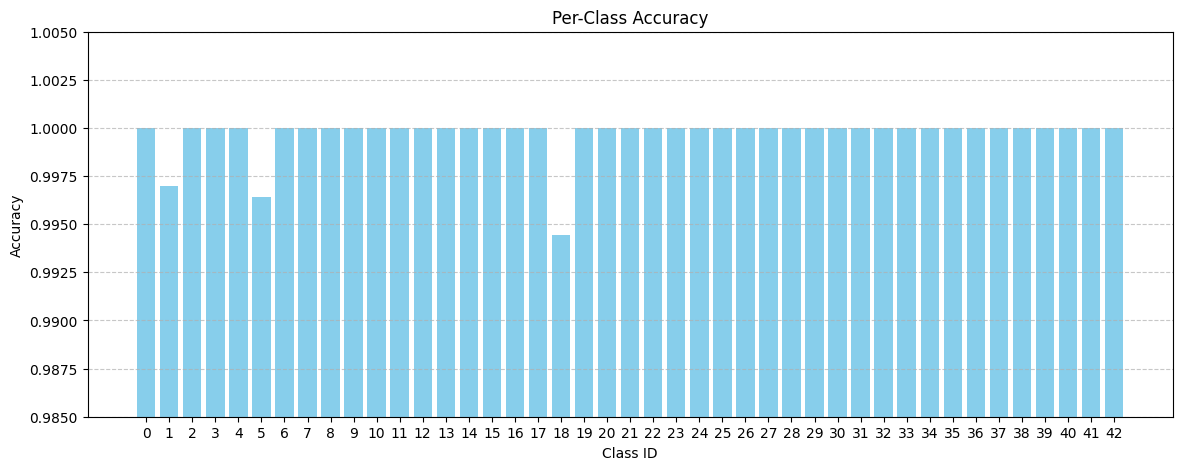

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


y_true = val_df['ClassId']
y_pred = model.predict(val_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

class_accuracy = cm.diagonal() / cm.sum(axis=1)

plt.figure(figsize=(14,5))
plt.bar(range(len(class_accuracy)), class_accuracy, color='skyblue')
plt.xlabel("Class ID")
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy")
plt.xticks(range(len(class_accuracy)))
plt.ylim(0.985, 1.005)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.15
)

train_dir = "/content/GTS/Train"
test_dir  = "/content/GTS/Test"


In [ ]:
train_gen = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='sparse',
    shuffle=True,
    subset='training'
)

val_gen = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='sparse',
    shuffle=False,
    subset='validation'
)


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)


ge_test_df['ClassId'] = ge_test_df['ClassId'].astype(str)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=ge_test_df,
    directory="/content/GTS",
    x_col='Path',
    y_col='ClassId',
    target_size=(48,48),
    batch_size=64,
    class_mode='sparse',
    shuffle=False
)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn(input_shape=(48, 48, 3), num_classes=43):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.4),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_cnn()
model.summary()


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

lr_cb = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3)
ckpt_cb = ModelCheckpoint('best_cnn_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')

history = model.fit(
    train_gen,
    epochs=25,
    validation_data=val_gen,
    callbacks=[lr_cb, ckpt_cb]
)


In [ ]:
model.load_weights('best_cnn_model.keras')

val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {val_acc:.4f}")


In [ ]:
model.load_weights('best_cnn_model.keras')
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

train_acc = history.history['accuracy']
val_acc   = history.history['val_accuracy']
epochs    = range(1, len(train_acc) + 1)

test_acc_list = [test_acc] * len(epochs)

plt.figure(figsize=(10,6))
plt.plot(epochs, train_acc, 'b-', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g-', label='Validation Accuracy')
plt.plot(epochs, test_acc_list, 'r--', label=f'Test Accuracy ({test_acc*100:.2f}%)')

plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
train_loss = history.history['loss']
val_loss   = history.history['val_loss']

plt.figure(figsize=(10,6))
plt.plot(epochs, train_loss, 'b-', label='Train Loss')
plt.plot(epochs, val_loss, 'g-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
